In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_classif


In [ ]:
data_path = "../../Entrega2/notebooks/motion_data_entrega2.csv"
df_raw = pd.read_csv(data_path)

print(df_raw.shape)
df_raw.head()


(4399, 138)


,frame_number,clip_name,coord_x_0,coord_y_0,coord_z_0,confidence_0,coord_x_1,coord_y_1,coord_z_1,confidence_1,...,coord_z_31,confidence_31,coord_x_32,coord_y_32,coord_z_32,confidence_32,movement_type,speed,camera_angle,camera_distance
0,13,Adelante_Lento_Centro_Cerca.mp4,0.145786,0.831212,-0.192980,0.968410,0.154933,0.837625,-0.222373,0.960158,...,0.078209,0.223389,0.098430,0.702435,0.312505,0.090072,caminar_adelante,lento,Centro,Cerca
1,14,Adelante_Lento_Centro_Cerca.mp4,0.141190,0.830624,-0.105090,0.967180,0.154717,0.839243,-0.127801,0.959875,...,0.010112,0.224492,0.091148,0.703466,0.190982,0.091250,caminar_adelante,lento,Centro,Cerca
2,15,Adelante_Lento_Centro_Cerca.mp4,0.146676,0.834547,0.030616,0.967366,0.160302,0.840530,0.006753,0.960517,...,-0.045836,0.223276,0.086657,0.711314,0.134295,0.096114,caminar_adelante,lento,Centro,Cerca
3,16,Adelante_Lento_Centro_Cerca.mp4,0.135671,0.836773,0.001077,0.968096,0.157984,0.842521,-0.017611,0.961277,...,0.031465,0.210945,0.099532,0.805248,0.188335,0.094065,caminar_adelante,lento,Centro,Cerca
4,17,Adelante_Lento_Centro_Cerca.mp4,0.134275,0.837998,-0.036210,0.969694,0.146348,0.842373,-0.056253,0.963132,...,0.029076,0.214194,0.112159,0.777486,0.189646,0.105636,caminar_adelante,lento,Centro,Cerca


In [ ]:
critical_landmarks = {
    0: 'nose',
    11: 'left_shoulder', 12: 'right_shoulder',
    15: 'left_wrist', 16: 'right_wrist',
    23: 'left_hip', 24: 'right_hip',
    25: 'left_knee', 26: 'right_knee',
    27: 'left_ankle', 28: 'right_ankle'
}

df = df_raw.copy()

rename_map = {}
for idx, name in critical_landmarks.items():
    rename_map[f'coord_x_{idx}'] = f'{name}_x'
    rename_map[f'coord_y_{idx}'] = f'{name}_y'
    rename_map[f'coord_z_{idx}'] = f'{name}_z'
    rename_map[f'confidence_{idx}'] = f'{name}_confidence'

df = df.rename(columns=rename_map)

print("Ejemplo de columnas con 'hip':")
[col for col in df.columns if 'hip' in col][:10]


Ejemplo de columnas con 'hip':


['left_hip_x',
 'left_hip_y',
 'left_hip_z',
 'left_hip_confidence',
 'right_hip_x',
 'right_hip_y',
 'right_hip_z',
 'right_hip_confidence']

In [ ]:
def create_feature_views(df):
    """Crea 3 vistas de features (igual que en Entrega2)."""
    base_cols = ['frame_number', 'clip_name', 'movement_type', 'speed']

    # VISTA A: Todo el cuerpo
    all_cols = [col for col in df.columns
                if col not in base_cols and col not in ['camera_angle', 'camera_distance']]
    view_a = df[base_cols + all_cols].copy()

    # VISTA B: Core (caderas + tronco + hombros)
    core_landmarks = ['nose', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    core_cols = [col for col in df.columns
                 if any(lm in col for lm in core_landmarks)]
    view_b = df[base_cols + core_cols].copy()

    # VISTA C: Piernas
    lower_landmarks = ['left_hip', 'right_hip', 'left_knee', 'right_knee',
                       'left_ankle', 'right_ankle']
    lower_cols = [col for col in df.columns
                  if any(lm in col for lm in lower_landmarks)]
    view_c = df[base_cols + lower_cols].copy()

    return view_a, view_b, view_c

view_a, view_b, view_c = create_feature_views(df)

print("Vista A:", view_a.shape)
print("Vista B (Core):", view_b.shape)
print("Vista C:", view_c.shape)

feature_cols_b = [c for c in view_b.columns
                  if c not in ['frame_number', 'clip_name', 'movement_type', 'speed']]
print("Features Vista B (Core):", len(feature_cols_b))
feature_cols_b[:10]


Vista A: (4399, 136)
Vista B (Core): (4399, 24)
Vista C: (4399, 28)
Features Vista B (Core): 20


['nose_x',
 'nose_y',
 'nose_z',
 'nose_confidence',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'left_shoulder_confidence',
 'right_shoulder_x',
 'right_shoulder_y']

In [ ]:
def prepare_data(view_df, test_size=0.2, val_size=0.125, random_state=42):
    """
    Prepara datos con split estratificado por CLIP.
    Devuelve X_train/X_val/X_test escalados + y + nombres de features.
    """

    X = view_df.drop(['movement_type', 'clip_name', 'frame_number', 'speed'], axis=1)
    y = view_df['movement_type']
    clips = view_df['clip_name']
    speed = view_df['speed']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    unique_clips = clips.unique()
    clip_labels = view_df.groupby('clip_name')['movement_type'].first()

    clips_train_val, clips_test = train_test_split(
        unique_clips, test_size=test_size, random_state=random_state,
        stratify=clip_labels
    )

    clip_labels_train_val = clip_labels[clips_train_val]
    clips_train, clips_val = train_test_split(
        clips_train_val, test_size=val_size, random_state=random_state,
        stratify=clip_labels_train_val
    )

    train_mask = clips.isin(clips_train)
    val_mask = clips.isin(clips_val)
    test_mask = clips.isin(clips_test)

    X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
    y_train, y_val, y_test = y_encoded[train_mask], y_encoded[val_mask], y_encoded[test_mask]
    speed_train, speed_val, speed_test = speed[train_mask], speed[val_mask], speed[test_mask]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Train: {X_train.shape[0]} frames, {len(clips_train)} clips")
    print(f"Val:   {X_val.shape[0]} frames, {len(clips_val)} clips")
    print(f"Test:  {X_test.shape[0]} frames, {len(clips_test)} clips")

    return {
        'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'speed_train': speed_train, 'speed_val': speed_val, 'speed_test': speed_test,
        'scaler': scaler, 'label_encoder': label_encoder,
        'feature_names': X.columns.tolist()
    }


In [ ]:
data_b = prepare_data(view_b)

X_train = data_b['X_train']
X_val   = data_b['X_val']
X_test  = data_b['X_test']

y_train = data_b['y_train']
y_val   = data_b['y_val']
y_test  = data_b['y_test']

feature_names = data_b['feature_names']

print("\nNúmero de features (Vista B/Core):", len(feature_names))
feature_names


Train: 3176 frames, 42 clips
Val:   489 frames, 6 clips
Test:  734 frames, 12 clips

Número de features (Vista B/Core): 20


['nose_x',
 'nose_y',
 'nose_z',
 'nose_confidence',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'left_shoulder_confidence',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_z',
 'right_shoulder_confidence',
 'left_hip_x',
 'left_hip_y',
 'left_hip_z',
 'left_hip_confidence',
 'right_hip_x',
 'right_hip_y',
 'right_hip_z',
 'right_hip_confidence']

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

X_test_full = X_test

print("X_train_full:", X_train_full.shape)
print("X_test_full: ", X_test_full.shape)


X_train_full: (3665, 20)
X_test_full:  (734, 20)


In [ ]:
best_rf_params = {
    "n_estimators": 200, 
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "random_state": 42,
    "n_jobs": -1
}

rf_baseline = RandomForestClassifier(**best_rf_params)
rf_baseline.fit(X_train_full, y_train_full)

y_pred_base = rf_baseline.predict(X_test_full)

acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average="macro")

print(">>> Baseline RandomForest (todas las features Core)")
print("Accuracy:", acc_base)
print("F1-macro:", f1_base)
print()
print(classification_report(y_test, y_pred_base))


>>> Baseline RandomForest (todas las features Core)
Accuracy: 0.8106267029972752
F1-macro: 0.7896917536569502

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       147
           1       0.82      0.99      0.90       145
           2       0.96      1.00      0.98       185
           3       0.74      0.49      0.59       144
           4       0.55      0.78      0.64       113

    accuracy                           0.81       734
   macro avg       0.81      0.80      0.79       734
weighted avg       0.83      0.81      0.81       734



Total componentes PCA: 20


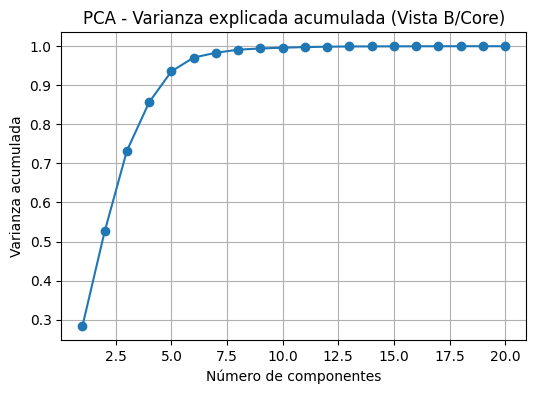

{0.9: 5, 0.95: 6, 0.99: 8}

In [ ]:
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_train_full)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

n_components = len(explained_var)
print("Total componentes PCA:", n_components)

plt.figure(figsize=(6, 4))
plt.plot(range(1, n_components + 1), cumulative_var, marker="o")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.title("PCA - Varianza explicada acumulada (Vista B/Core)")
plt.grid(True)
plt.show()

thresholds = [0.90, 0.95, 0.99]
components_for_threshold = {}

for t in thresholds:
    k = np.argmax(cumulative_var >= t) + 1
    components_for_threshold[t] = k

components_for_threshold


In [ ]:
pca_results = []

for t, k in components_for_threshold.items():
    print(f"\n=== PCA con {k} componentes (varianza ≥ {int(t*100)}%) ===")
    
    pca = PCA(n_components=k, random_state=42)
    X_train_pca = pca.fit_transform(X_train_full)
    X_test_pca  = pca.transform(X_test_full)
    
    rf_pca = RandomForestClassifier(**best_rf_params)
    rf_pca.fit(X_train_pca, y_train_full)
    
    y_pred_pca = rf_pca.predict(X_test_pca)
    
    acc = accuracy_score(y_test, y_pred_pca)
    f1 = f1_score(y_test, y_pred_pca, average="macro")
    
    print("Accuracy:", acc)
    print("F1-macro:", f1)
    
    pca_results.append({
        "method": "PCA",
        "variant": f"PCA_{int(t*100)}",
        "n_features": k,
        "accuracy": acc,
        "f1_macro": f1
    })



=== PCA con 5 componentes (varianza ≥ 90%) ===
Accuracy: 0.5912806539509536
F1-macro: 0.5462921348815316

=== PCA con 6 componentes (varianza ≥ 95%) ===
Accuracy: 0.6021798365122616
F1-macro: 0.5642866666950408

=== PCA con 8 componentes (varianza ≥ 99%) ===
Accuracy: 0.6280653950953679
F1-macro: 0.5904654349083573


In [ ]:
n_total_features = X_train_full.shape[1]
n_features_list = [10, 20, 30, n_total_features]

rfe_results = []
rfe_selected_features = {}

for k in n_features_list:
    print(f"\n=== RFE con {k} features ===")
    
    base_estimator = RandomForestClassifier(**best_rf_params)
    rfe = RFE(estimator=base_estimator,
              n_features_to_select=k,
              step=1)
    
    rfe.fit(X_train_full, y_train_full)

    selected_mask = rfe.support_
    selected_feats = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
    rfe_selected_features[k] = selected_feats
    
    print("Features seleccionadas:", selected_feats)

    X_train_rfe = rfe.transform(X_train_full)
    X_test_rfe  = rfe.transform(X_test_full)
    
    rf_rfe = RandomForestClassifier(**best_rf_params)
    rf_rfe.fit(X_train_rfe, y_train_full)
    
    y_pred_rfe = rf_rfe.predict(X_test_rfe)
    
    acc = accuracy_score(y_test, y_pred_rfe)
    f1 = f1_score(y_test, y_pred_rfe, average="macro")
    
    print("Accuracy:", acc)
    print("F1-macro:", f1)
    
    rfe_results.append({
        "method": "RFE",
        "variant": f"RFE_{k}",
        "n_features": k,
        "accuracy": acc,
        "f1_macro": f1
    })



=== RFE con 10 features ===
Features seleccionadas: ['nose_confidence', 'left_shoulder_x', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_confidence', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_y', 'right_hip_z']
Accuracy: 0.8051771117166212
F1-macro: 0.7847498825681819

=== RFE con 20 features ===
Features seleccionadas: ['nose_x', 'nose_y', 'nose_z', 'nose_confidence', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_confidence', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_confidence', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_confidence']
Accuracy: 0.8106267029972752
F1-macro: 0.7896917536569502

=== RFE con 30 features ===


C:\Users\santi\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=30 > n_features=20. There will be no feature selection and all features will be kept.
  warnings.warn(


Features seleccionadas: ['nose_x', 'nose_y', 'nose_z', 'nose_confidence', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_confidence', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_confidence', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_confidence']
Accuracy: 0.8106267029972752
F1-macro: 0.7896917536569502

=== RFE con 20 features ===
Features seleccionadas: ['nose_x', 'nose_y', 'nose_z', 'nose_confidence', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_confidence', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_confidence', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_confidence']
Accuracy: 0.8106267029972752
F1-macro: 0.7896917536569502


In [ ]:
mi_scores = mutual_info_classif(X_train_full, y_train_full, random_state=42)

mi_df = pd.DataFrame({
    "feature": feature_names,
    "mi_score": mi_scores
}).sort_values("mi_score", ascending=False).reset_index(drop=True)

print("Top 15 features según MI:")
mi_df.head(15)


Top 15 features según MI:


,feature,mi_score
0,left_hip_y,0.716974
1,right_hip_z,0.695599
2,left_hip_z,0.694461
3,right_hip_y,0.686088
4,nose_y,0.660981
5,right_shoulder_y,0.656529
6,left_shoulder_y,0.650784
7,nose_confidence,0.538907
8,left_shoulder_confidence,0.527546
9,left_hip_x,0.521210


In [ ]:
mi_results = {}
mi_rf_results = []

top_k_list = [10, 20, 30, n_total_features]

for k in top_k_list:
    print(f"\n=== MI: top-{k} features ===")
    
    top_features = mi_df.head(k)["feature"].tolist()
    mi_results[k] = top_features
    
    print("Features seleccionadas:", top_features)
    
    idxs = [feature_names.index(f) for f in top_features]
    
    X_train_mi = X_train_full[:, idxs]
    X_test_mi  = X_test_full[:, idxs]
    
    rf_mi = RandomForestClassifier(**best_rf_params)
    rf_mi.fit(X_train_mi, y_train_full)
    
    y_pred_mi = rf_mi.predict(X_test_mi)
    
    acc = accuracy_score(y_test, y_pred_mi)
    f1 = f1_score(y_test, y_pred_mi, average="macro")
    
    print("Accuracy:", acc)
    print("F1-macro:", f1)
    
    mi_rf_results.append({
        "method": "MI",
        "variant": f"MI_top{k}",
        "n_features": k,
        "accuracy": acc,
        "f1_macro": f1
    })



=== MI: top-10 features ===
Features seleccionadas: ['left_hip_y', 'right_hip_z', 'left_hip_z', 'right_hip_y', 'nose_y', 'right_shoulder_y', 'left_shoulder_y', 'nose_confidence', 'left_shoulder_confidence', 'left_hip_x']
Accuracy: 0.7629427792915532
F1-macro: 0.746900832374236

=== MI: top-20 features ===
Features seleccionadas: ['left_hip_y', 'right_hip_z', 'left_hip_z', 'right_hip_y', 'nose_y', 'right_shoulder_y', 'left_shoulder_y', 'nose_confidence', 'left_shoulder_confidence', 'left_hip_x', 'left_hip_confidence', 'left_shoulder_x', 'left_shoulder_z', 'right_hip_x', 'nose_z', 'right_shoulder_x', 'nose_x', 'right_hip_confidence', 'right_shoulder_z', 'right_shoulder_confidence']
Accuracy: 0.7983651226158038
F1-macro: 0.7775932012458785

=== MI: top-30 features ===
Features seleccionadas: ['left_hip_y', 'right_hip_z', 'left_hip_z', 'right_hip_y', 'nose_y', 'right_shoulder_y', 'left_shoulder_y', 'nose_confidence', 'left_shoulder_confidence', 'left_hip_x', 'left_hip_confidence', 'left_s

In [ ]:
all_results = []

all_results.append({
    "method": "Baseline",
    "variant": "RF_all_core",
    "n_features": n_total_features,
    "accuracy": acc_base,
    "f1_macro": f1_base
})

all_results.extend(pca_results)
all_results.extend(rfe_results)
all_results.extend(mi_rf_results)

results_df = pd.DataFrame(all_results)
results_df.sort_values(["f1_macro", "accuracy"], ascending=False, inplace=True)

results_df


,method,variant,n_features,accuracy,f1_macro
0,Baseline,RF_all_core,20,0.810627,0.789692
5,RFE,RFE_20,20,0.810627,0.789692
6,RFE,RFE_30,30,0.810627,0.789692
7,RFE,RFE_20,20,0.810627,0.789692
4,RFE,RFE_10,10,0.805177,0.784750
9,MI,MI_top20,20,0.798365,0.777593
10,MI,MI_top30,30,0.798365,0.777593
11,MI,MI_top20,20,0.798365,0.777593
8,MI,MI_top10,10,0.762943,0.746901
3,PCA,PCA_99,8,0.628065,0.590465


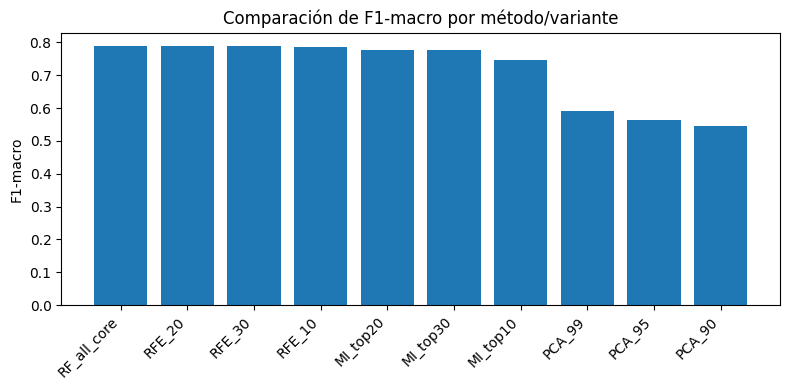

In [15]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["variant"], results_df["f1_macro"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-macro")
plt.title("Comparación de F1-macro por método/variante")
plt.tight_layout()
plt.show()


In [ ]:
import os

output_dir = "../src"
os.makedirs(output_dir, exist_ok=True)

results_df.to_csv(os.path.join(output_dir, "feature_selection_results.csv"), index=False)

rfe_features_df = pd.DataFrame([
    {"method": "RFE", "k": k, "feature": f}
    for k, feats in rfe_selected_features.items()
    for f in feats
])
rfe_features_df.to_csv(os.path.join(output_dir, "rfe_selected_features.csv"), index=False)

mi_features_df = pd.DataFrame([
    {"method": "MI", "k": k, "feature": f}
    for k, feats in mi_results.items()
    for f in feats
])
mi_features_df.to_csv(os.path.join(output_dir, "mi_selected_features.csv"), index=False)


In [ ]:
optimal_features = rfe_selected_features[10]
print("Features del modelo reducido (RFE_10):")
optimal_features


Features del modelo reducido (RFE_10):


['nose_confidence',
 'left_shoulder_x',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_confidence',
 'left_hip_y',
 'left_hip_z',
 'left_hip_confidence',
 'right_hip_y',
 'right_hip_z']

In [ ]:
idx_opt = [feature_names.index(f) for f in optimal_features]

X_train_opt = X_train_full[:, idx_opt]
X_test_opt  = X_test_full[:, idx_opt]

print("X_train_opt shape:", X_train_opt.shape)
print("X_test_opt shape:", X_test_opt.shape)

rf_opt = RandomForestClassifier(**best_rf_params)
rf_opt.fit(X_train_opt, y_train_full)

y_pred_opt = rf_opt.predict(X_test_opt)

acc_opt = accuracy_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt, average="macro")

print(">>> Modelo reducido RF + RFE_10")
print("Accuracy:", acc_opt)
print("F1-macro:", f1_opt)
print()
print(classification_report(y_test, y_pred_opt))


X_train_opt shape: (3665, 10)
X_test_opt shape: (734, 10)
>>> Modelo reducido RF + RFE_10
Accuracy: 0.8051771117166212
F1-macro: 0.7847498825681819

              precision    recall  f1-score   support

           0       0.98      0.68      0.80       147
           1       0.82      0.99      0.89       145
           2       0.89      1.00      0.94       185
           3       0.79      0.51      0.62       144
           4       0.57      0.80      0.67       113

    accuracy                           0.81       734
   macro avg       0.81      0.79      0.78       734
weighted avg       0.83      0.81      0.80       734



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

label_encoder = data_b['label_encoder']
class_names = label_encoder.classes_
print("Clases:", class_names)

prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(
    y_test, y_pred_base, average=None
)

prec_o, rec_o, f1_o, _ = precision_recall_fscore_support(
    y_test, y_pred_opt, average=None
)

per_class_df = pd.DataFrame({
    "class": class_names,
    "precision_base": prec_b,
    "recall_base": rec_b,
    "f1_base": f1_b,
    "precision_opt": prec_o,
    "recall_opt": rec_o,
    "f1_opt": f1_o,
})

per_class_df


Clases: ['caminar_adelante' 'caminar_atras' 'girar' 'levantarse' 'sentarse']


,class,precision_base,recall_base,f1_base,precision_opt,recall_opt,f1_opt
0,caminar_adelante,0.981982,0.741497,0.844961,0.980392,0.680272,0.803213
1,caminar_atras,0.821839,0.986207,0.896552,0.817143,0.986207,0.893750
2,girar,0.958549,1.000000,0.978836,0.889423,1.000000,0.941476
3,levantarse,0.736842,0.486111,0.585774,0.793478,0.506944,0.618644
4,sentarse,0.546584,0.778761,0.642336,0.573248,0.796460,0.666667


In [ ]:
import time

def measure_times(model, X_train, y_train, X_test, n_repeat=5):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    infer_times = []
    for _ in range(n_repeat):
        t0 = time.time()
        _ = model.predict(X_test)
        infer_times.append(time.time() - t0)

    return train_time, np.mean(infer_times)

rf_base_timing = RandomForestClassifier(**best_rf_params)
train_t_base, infer_t_base = measure_times(
    rf_base_timing, X_train_full, y_train_full, X_test_full
)

rf_opt_timing = RandomForestClassifier(**best_rf_params)
train_t_opt, infer_t_opt = measure_times(
    rf_opt_timing, X_train_opt, y_train_full, X_test_opt
)

print("Base - train (s):", train_t_base, "  infer (s):", infer_t_base)
print("Opt  - train (s):", train_t_opt,  "  infer (s):", infer_t_opt)


Base - train (s): 0.25877952575683594   infer (s): 0.030792713165283203
Opt  - train (s): 0.22864699363708496   infer (s): 0.026211261749267578


In [ ]:
speed_test = data_b['speed_test'].reset_index(drop=True)

df_eval = pd.DataFrame({
    "true_label": y_test,
    "pred_base": y_pred_base,
    "pred_opt": y_pred_opt,
    "speed": speed_test.values
})

speeds = df_eval["speed"].unique()
speeds


array(['lento', 'rapido'], dtype=object)

In [22]:
from sklearn.metrics import f1_score

rows = []
for s in speeds:
    mask = df_eval["speed"] == s
    f1_b_s = f1_score(df_eval.loc[mask, "true_label"],
                      df_eval.loc[mask, "pred_base"],
                      average="macro")
    f1_o_s = f1_score(df_eval.loc[mask, "true_label"],
                      df_eval.loc[mask, "pred_opt"],
                      average="macro")
    rows.append({
        "speed": s,
        "f1_base": f1_b_s,
        "f1_opt": f1_o_s,
        "n_frames": mask.sum()
    })

speed_results = pd.DataFrame(rows)
speed_results


,speed,f1_base,f1_opt,n_frames
0,lento,0.537701,0.512681,264
1,rapido,0.583701,0.587923,470


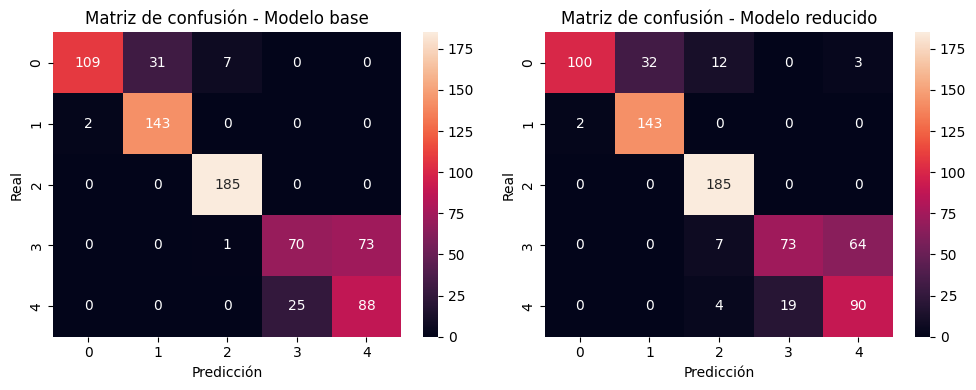

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_base = confusion_matrix(y_test, y_pred_base)
cm_opt  = confusion_matrix(y_test, y_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_base, annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo base")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_opt, annot=True, fmt="d", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo reducido")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


In [ ]:
import os
import joblib
import json

model_dir = "../src/model"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "rf_core_rfe10.pkl")
joblib.dump(rf_opt, model_path)

scaler_path = os.path.join(model_dir, "scaler_core.pkl")
joblib.dump(data_b['scaler'], scaler_path)

le_path = os.path.join(model_dir, "label_encoder.pkl")
joblib.dump(data_b['label_encoder'], le_path)

meta = {
    "feature_names": feature_names,
    "selected_features": optimal_features
}

meta_path = os.path.join(model_dir, "model_metadata.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

model_path, scaler_path, le_path, meta_path


('../src/model\\rf_core_rfe10.pkl',
 '../src/model\\scaler_core.pkl',
 '../src/model\\label_encoder.pkl',
 '../src/model\\model_metadata.json')